# 1/fゆらぎを超高音でやってみる

- モスキート音ってあるじゃん
- 若者に耳障りな音として、たむろ防止に使われてるじゃん
- 1/fゆらぎってあるじゃん
- 人間が心地いいって感じる音らしいじゃん
- 混ぜたら「若者は聞こえる心地いい音」が作れるんじゃね？

というバカなことを思い立った次第

## 1. 音を作ろう

適当に転がってるやつを使って、一定周波数の音を作る

https://fabeee.co.jp/blog/sugichan02/ <br>
https://qiita.com/bayachin/items/68f7659d31fa6c836317

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import wave
import struct

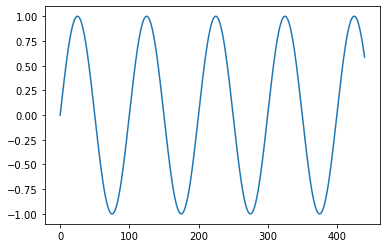

In [3]:
sec = 0.01
SAMPLE_RATE = 44100

# 経過時間tに対応するがyがnparray形式で取得できる
t = np.arange(0, SAMPLE_RATE * sec) # 0からSAMPLE_RATE * sec - 1までの1刻みの配列
y = np.sin(2 * np.pi * 441 * t / SAMPLE_RATE)

# グラフにしてみる
plt.plot(t, y)
plt.show()

なんかややこしいことしてるけど、言ってしまえば「1/100Hzのsin波」

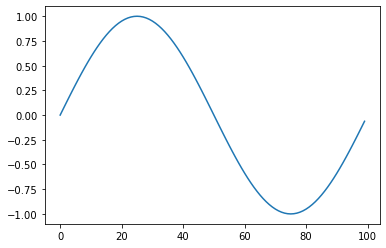

In [4]:
plt.plot(t[:100], y[:100])
plt.show()

そんなこんなで関数作成

In [5]:
## 各種定数
VOLUME = 1
SAMPLE_RATE = 44100

In [6]:
def generate_tone(tones=[261.626], sec=2, VOLUME=VOLUME):
    """
    周波数の配列を生成して返却

    Args:
        tones (list): 生成する音の周波数
        sec (float): 再生時間

    Returns:
        list: 生成された波形配列
    """
    t = np.arange(0, SAMPLE_RATE * sec)
    y = None

    for tone in tones:
        # 和音対応（各音の配列を足し合わせると和音になる）
        if y is None:
            y = VOLUME * np.sin(2 * np.pi * tone * t / SAMPLE_RATE)
        else:
            y += VOLUME * np.sin(2 * np.pi * tone * t / SAMPLE_RATE)
            
    return y

In [7]:
def save_as_wave(y, filename = "test.wav"):
    """
    waveファイル出力

    Args:
        y (ndarray): wavファイルに出力する波形配列
        filename (str): 出力ファイル名

    Returns:
        None
    """
    max_num = 32767 / max(y) # int16は-32768~32767の範囲
    bit = [int(x * max_num) for x in y] # 16bit符号付き整数に変換
    waves = struct.pack("h" * len(bit), *bit) # バイナリ化，'h'が2byte整数のフォーマット
    with wave.Wave_write(filename) as w:
        # (チャンネル数(1:モノラル,2:ステレオ))
        # サンプルサイズ(バイト)
        # サンプリング周波数
        # フレーム数
        # 圧縮形式(今のところNONEのみ)
        # 圧縮形式を人に判読可能な形にしたもの？通常、'NONE'に対して'not compressed'が返される)
        w.setparams((1, 2, SAMPLE_RATE, len(waves), 'NONE', 'not compressed'))
        w.writeframes(waves)

In [8]:
def show_wave(y, show_sec=None):
    """
    入力波形のグラフを表示
    
    y：表示する波形
    show_wave：表示秒（デフォでは入力波形の最大時間）
    
    返り値：なし
    """
    if show_sec is None or show_sec > (len(y) / SAMPLE_RATE):
        show_sec = len(y) / SAMPLE_RATE

    plt.plot([i/SAMPLE_RATE for i in range(int(show_sec * SAMPLE_RATE))], y[:int(show_sec * SAMPLE_RATE)])
    plt.show()

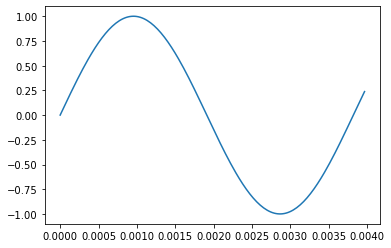

In [9]:
y = generate_tone()
save_as_wave(y)
show_wave(y, 0.004)

## 2. パワースペクトルを表示

周波数とエネルギーの関係をグラフ化したもの

フーリエ変換後のグラフと違うん？

http://climbsd.lowtem.hokudai.ac.jp/group/shigeru/tc/dataan2012/num5.pdf

フーリエ変換の2乗値ってことでOK？

実装自体は大したことない<br>
https://qiita.com/kaityo256/items/64a54bb2e2c477cc6fa1 <br>
https://momonoki2017.blogspot.com/2018/03/pythonfft-1-fft.html

横軸は入力の全体を1秒とした時のHz

振幅はデータ数の半分で割る必要あり

In [10]:
def show_Amp(y, sec, show=False):
    # 高速フーリエ変換
    fk = np.fft.fft(y)
    # 振幅スペクトル
    Amp = abs(fk)
    
    x = [i/sec for i in range(int(len(Amp)/2))]
    Amp = Amp[:len(x)]/(len(Amp)/2)
    
    if show:
        plt.plot(x, Amp)
    
    return x, Amp

In [11]:
x,Amp = show_Amp(y, 2)

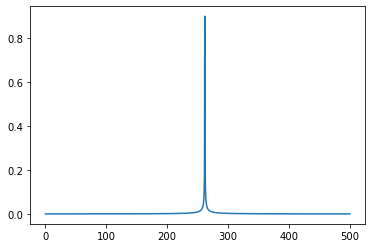

In [12]:
plt.plot(x[:1000],Amp[:1000])

In [13]:
for i,j in zip(x,Amp):
    if j > 0.5:
        print(i)

261.5


パワースペクトルは二乗するだけでいいらしい

In [14]:
def show_Pow(Amp, show=False):
    Pow = Amp ** 2
    
    if show:
        plt.plot(x, Pow)
    
    return x, Pow

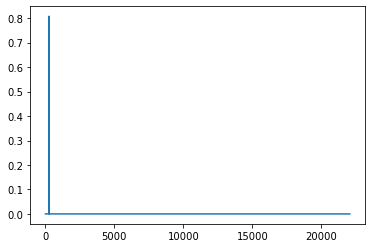

In [15]:
x,Pow = show_Pow(Amp, True)

## 3. 1/fゆらぎ作成

パワースペクトルが1/fになっとったらええらしい

In [16]:
from tqdm import tqdm

In [17]:
# 1000Hz～20000Hzまで100刻みで合成
freqs = [freq for freq in range(0,20001,100)]

In [18]:
(1/10000) ** (1/2)

0.01

In [19]:
sec = 3
for freq in tqdm(freqs[1:]):
    Vol = (1/freq) ** (1/2)
    if freq == 100:
        yuragi = generate_tone([freq], sec, VOLUME=Vol)
#         break
    else:
        yuragi = np.add(yuragi, generate_tone([freq], sec, VOLUME=Vol))

100%|██████████| 200/200 [00:01<00:00, 175.70it/s]


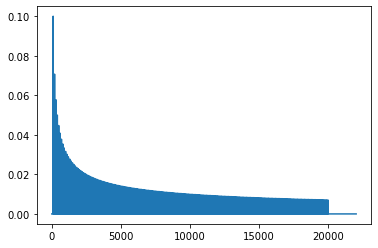

In [20]:
x,Amp = show_Amp(yuragi, sec, True)

In [21]:
# for i,j in zip(x,Amp):
#     if j > 0.005:
#         print(i)

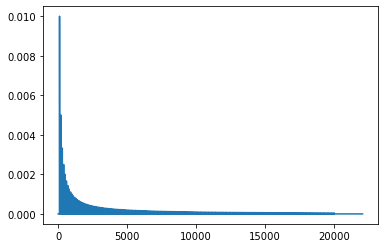

In [22]:
x,Pow = show_Pow(Amp, True)

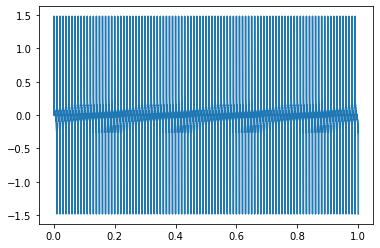

In [23]:
show_wave(yuragi,1)

In [24]:
# for i,j in zip(x,Pow):
#     if j > 0.00005:
#         print(i,j,1/i)

In [25]:
save_as_wave(yuragi, 'yuragi_nomal.wav')

そこまで良い音には感じない

In [26]:
# 800Hz～20000Hzまで100刻みで合成
freqs = [freq for freq in range(12000,20001,100)]

sec = 30
for freq in tqdm(freqs):
    Vol = (10/freq) ** (1/2)
    if freq == 12000:
        yuragi = generate_tone([freq], sec, VOLUME=Vol)
#         break
    else:
        yuragi = np.add(yuragi, generate_tone([freq], sec, VOLUME=Vol))

100%|██████████| 81/81 [00:04<00:00, 17.47it/s]


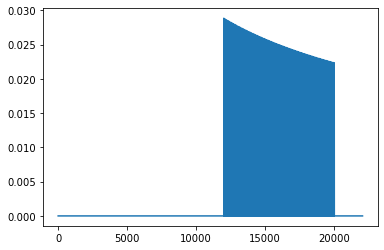

In [27]:
x,Amp = show_Amp(yuragi, sec, True)

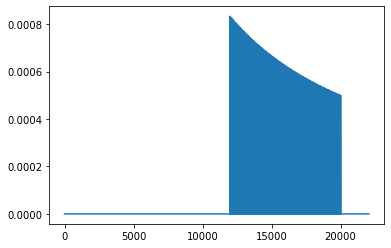

In [28]:
x,Pow = show_Pow(Amp, True)

In [29]:
# with open("test.csv","w") as f:
#     for i,j in zip(x,Pow):
#         f.write(str(i)+","+str(j)+"\n")

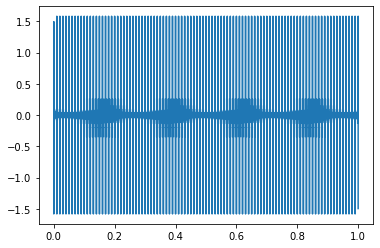

In [30]:
show_wave(yuragi,1)

In [31]:
save_as_wave(yuragi, 'yuragi_hi.wav')

小さすぎて聞こえんナリ

大きくした

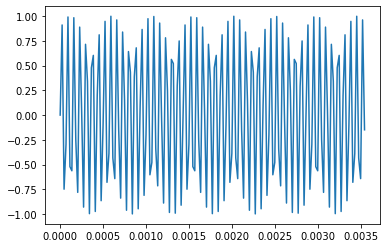

In [32]:
# 14000Hzの波形を出力
show_wave(generate_tone(tones=[14000]),1/140/2)

In [33]:
save_as_wave(generate_tone(tones=[14000],sec=10),"14000Hz.wav")